# SCRIPT NAME: GDI_FCN_TRAIN.ipynb
THIS SCRIPT DOES THE FOLLOWING FUNCTIONALITIES:

          1. PRE_PROCESS GDI DATASET
          2. TRAIN THE FCN-16 MODEL ON GDI DATA
          3. Visualize training performance
          4. TEST ON THE PERFORMANCE ON TEST DATA
          5. SAVE THE MODEL FOR LATER USE

In [0]:
# import libraries
import tensorflow
import keras
import random
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image


Using TensorFlow backend.


In [0]:
# comment this part if not using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Visualisation

1004_4721235550_b7c0ea7c33_z.png
1004_4721235550_b7c0ea7c33_z.jpg


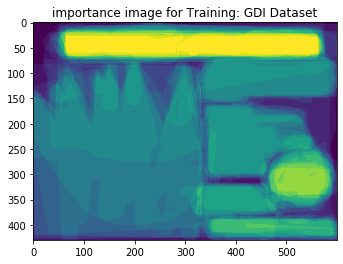

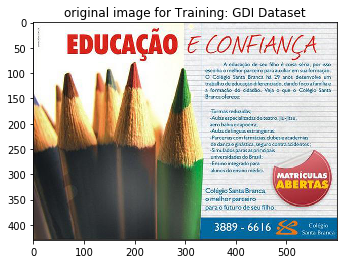

In [0]:

# Path to the training and testing GDI data
dir_data = "/content/drive/My Drive/HCI_prep/GDI/"

dir_seg_test = dir_data + "/gd_imp_val/"
dir_img_test = dir_data + "/gd_val/"
dir_seg_train = dir_data + "/gd_imp_train/"
dir_img_train = dir_data + "/gd_train/"

ldseg = np.array(os.listdir(dir_seg_train))
ldseg_tr = np.array(os.listdir(dir_img_train))


## pick the first image from GDI Dataset and Visualise
fnm = ldseg[0]
fnm_tr= ldseg_tr[0]

print(fnm)
print(fnm_tr)

img=mpimg.imread(dir_seg_train+fnm)
imgplot = plt.imshow(img)
plt.title("importance image for Training: GDI Dataset")
plt.show()

img=mpimg.imread(dir_img_train+fnm_tr)
imgplot = plt.imshow(img)
plt.title("original image for Training: GDI Dataset")
plt.show()



# Data Preprocessing

In [0]:

n_classes=1
meanval=(104.00699, 116.66877, 122.67892)

output_width, output_height= 224,224
input_width, input_height=224,224

"""
Function Name: ImageArr()
Parameters: path, width, height
Functionalities: 1) Resizing to 224*224
                 2) Mean Value Reduction
                 3) RGB to BGR conversion

Returns: preprocessed image

"""

def ImageArr(path, width, height):
    #print(path)
    img = cv2.imread(path, 1)
    img = np.float32(cv2.resize(img, (width, height))) #/ 127.5 - 1
   
    # Meanvalue reduction
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img -= meanval
    
    return img


"""
Function Name: ImpArr()
Parameters: path,class, width, height
Functionalities: 1) BGR to GRAY conversion
                 2) Resizing to 224*224
                 2) values range from 0 to 255

Returns: preprocessed ground truth

"""

def ImpArr(path, classes, width, height):
   
    # ACCORDIG TO THE REF PAPER
    img = cv2.imread(path, 1)

    # convert to gray image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize to 224*224
    img = cv2.resize(img, (224,224))

    # values range from 0 to 255
    label = np.array(img, dtype=np.uint8) 
    
    #For classifiction problem, take the values of saliency map as positive sample,
    #if the value is more than 2/3 of 255 
    label = label>255.0*2/3
   
    label = np.expand_dims(label, axis=-1)
    #print("aftr expanding dim",label.shape)
   
    return label
    
images_train = os.listdir(dir_img_train)
images_train.sort()
#print("sorted",images_train)

imp_train = os.listdir(dir_seg_train)
imp_train.sort()
#print("sorted",imp_train )

images_test = os.listdir(dir_img_test)
images_test.sort()
#print("sorted",images_train )

imp_test = os.listdir(dir_seg_test)
imp_test.sort()
#print("sorted",imp_test )


# Append processed image arrays in separate lists
X_train = []
X_test = []

Y_train = []
Y_test = []

for im, seg in zip(images_train, imp_train):
     X_train.append(ImageArr(dir_img_train + im, input_width, input_height))
     Y_train.append(ImpArr(dir_seg_train + seg, n_classes, output_width, output_height))

for im, seg in zip(images_test, imp_test):
    X_test.append(ImageArr(dir_img_test + im, input_width, input_height))
    Y_test.append(ImpArr(dir_seg_test + seg, n_classes, output_width, output_height))

X_tr, Y_tr = np.array(X_train), np.array(Y_train)
print(X_tr.shape, Y_tr.shape)


X_tst, Y_tst = np.array(X_test), np.array(Y_test)
print(X_tst.shape, Y_tst.shape)

(862, 224, 224, 3) (862, 224, 224, 1)
(216, 224, 224, 3) (216, 224, 224, 1)


# TRAIN-VALIDATION-TEST SPLIT
Separate 10% data from Xtst and Ytst for testing. Use rest 90% data for validation while training.



In [0]:
from sklearn.utils import shuffle

validation_rate = 0.9
index_validation = np.random.choice(X_tst.shape[0],int(X_tst.shape[0]*validation_rate),replace=False)
#print(index_validation)
index_test= list(set(range(X_tst.shape[0])) - set(index_validation))
                            
X2, Y2 = shuffle(X_tst, Y_tst)
X_valid, Y_valid = X2[index_validation],Y2[index_validation]
X_test, Y_test = X2[index_test],Y2[index_test]


X_tr, Y_tr= shuffle(X_tr, Y_tr)
X_test, Y_test= shuffle(X_test, Y_test)
X_valid, Y_valid= shuffle(X_valid, Y_valid)

print("X_train and y_train shape are: ", X_tr.shape, Y_tr.shape)
print("X_valid and y_valid shape are: ",X_valid.shape, Y_valid.shape)
print("X_test and y_test shape are: ",X_test.shape, Y_test.shape)



X_train and y_train shape are:  (862, 224, 224, 3) (862, 224, 224, 1)
X_valid and y_valid shape are:  (194, 224, 224, 3) (194, 224, 224, 1)
X_test and y_test shape are:  (22, 224, 224, 3) (22, 224, 224, 1)


# FCN-16 model building

In [0]:
# import libraries for training the model
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import pandas as pd

'''
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
config =  tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "2"
'''
set_session(tf.compat.v1.Session())

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
keras version 2.2.5
tensorflow version 1.15.0


In [0]:
"""
Function Name: crop()
Parameters: feature map1, feature map 2,image input
Functionalities: crop feature map1 wrt.feature map 2
Returns: cropped o1 and o2
"""

def crop(o1, o2, i):
    o_shape2 = Model(i, o2).output_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height2 = o_shape2[2]
        output_width2 = o_shape2[3]
    else:
        output_height2 = o_shape2[1]
        output_width2 = o_shape2[2]

    o_shape1 = Model(i, o1).output_shape
    if IMAGE_ORDERING == 'channels_first':
        output_height1 = o_shape1[2]
        output_width1 = o_shape1[3]
    else:
        output_height1 = o_shape1[1]
        output_width1 = o_shape1[2]

    cx = abs(output_width1 - output_width2)
    cy = abs(output_height2 - output_height1)

    if output_width1 > output_width2:
        o1 = Cropping2D(cropping=((0, 0),  (0, cx)),
                        data_format=IMAGE_ORDERING)(o1)
    else:
        o2 = Cropping2D(cropping=((0, 0),  (0, cx)),
                        data_format=IMAGE_ORDERING)(o2)

    if output_height1 > output_height2:
        o1 = Cropping2D(cropping=((0, cy),  (0, 0)),
                        data_format=IMAGE_ORDERING)(o1)
    else:
        o2 = Cropping2D(cropping=((0, cy),  (0, 0)),
                        data_format=IMAGE_ORDERING)(o2)

    return o1, o2


In [0]:
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

IMAGE_ORDERING = 'channels_last'

# take vgg-16 pretrained model from "https://github.com/fchollet/deep-learning-models" here
pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

pretrained= 'imagenet' #'imagenet' if weights need to be initialized!


"""
Function Name: get_vgg_encoder()
Functionalities: This function defines the VGG encoder part of the FCN network
                 and initialize this encoder part with VGG pretrained weights.
Parameter:input_height=224,  input_width=224, pretrained=pretrained
Returns: final layer of every blocks as f1,f2,f3,f4,f5

"""
def get_vgg_encoder(input_height=224,  input_width=224, pretrained=pretrained):
    pad = 1

    # heights and weights must be divided by 32, for fcn
    assert input_height % 32 == 0 
    assert input_width % 32 == 0

   
    img_input = Input(shape=(input_height, input_width, 3))

    # Unlike base paper, stride=1 has not been used here, because
    # Keras has default stride=1

    x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='valid',name='block1_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',data_format=IMAGE_ORDERING)(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same',name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',data_format=IMAGE_ORDERING)(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same',name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',data_format=IMAGE_ORDERING)(x)
    x= Dropout(0.5)(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',data_format=IMAGE_ORDERING)(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',data_format=IMAGE_ORDERING)(x)
    #x= Dropout(0.5)(x)

    f5 = x

    # Check if weights are initialised, model is learning!
    if pretrained == 'imagenet':
        VGG_Weights_path = tensorflow.keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
        
        Model(img_input, x).load_weights(VGG_Weights_path)

    return img_input, [f1, f2, f3, f4, f5]

In [0]:

"""
Function Name: fcn_16()
Functionalities: This function defines the Fully Convolutional part of the FCN network
                 and adds skip connections to build FCN-16 network
Parameter:n_classes, encoder=get_vgg_encoder, input_height=224,input_width=224
Returns: model

"""

def fcn_16(n_classes, encoder=get_vgg_encoder, input_height=224,input_width=224):

    # Take levels from the base model, i.e. vgg
    img_input, levels = encoder(input_height=input_height,  input_width=input_width)
    [f1, f2, f3, f4, f5] = levels

    o = f5

    # fcn6
    o = (Conv2D(4096, (7, 7), activation='relu',padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)

    #fc7
    o = (Conv2D(4096, (1, 1), activation='relu',padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.3)(o)

    conv7 = (Conv2D(1, (1, 1), activation='relu', padding='same', name="score_sal", data_format=IMAGE_ORDERING))(o)

    conv7_4 = Conv2DTranspose(1, kernel_size=(4, 4), strides=(2, 2),padding='same', name= "upscore_sal2", use_bias=False, data_format=IMAGE_ORDERING)(conv7)
  
    pool411 = (
        Conv2D(1, (1, 1), activation='relu', padding='same', name="score_pool4", data_format=IMAGE_ORDERING))(f4)
  
    # Add a crop layer 
    o, o2 = crop( pool411,conv7_4, img_input)

    # add skip connection
    o = Add()([o, o2])

    # 16 x upsample
    o = Conv2DTranspose(n_classes, kernel_size=(32, 32), strides=(16, 16), use_bias=False, data_format=IMAGE_ORDERING)(o)

    #crop layer
    ## Caffe calls crop layer that takes o and img_input as argument, it takes their difference and crops
    ## But keras takes it as touple, I checked the size diff and put this value manually.
    ## output dim was 240 , input dim was 224. 240-224=16. so 16/2=8

    score= Cropping2D(cropping=((8,8), (8, 8)),data_format=IMAGE_ORDERING)(o)
    
    o = (Activation('sigmoid'))(score)
    model = Model(img_input, o)
    
    model.model_name = "fcn_16"
    
    return model

# Binary classification problem with 2 classes, salient or non-salient
model = fcn_16(n_classes=1, encoder=get_vgg_encoder, input_height=224,input_width=224)

# show model summary
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 226, 226, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
___________

# Training 

In [0]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model


#Check the layers and the weights
#Cros-validate the weights manually with the vgg weights opened with Netron API
#model.set_weights(model_pretrained)
for i,layer in enumerate(model.layers):
  print(i,layer.name)

  print(layer.get_weights())
  #print(i,layer.name)

# Freeze the first 19 layers
for layer in model.layers[:19]:
    print(layer.name)
    layer.trainable = False
  
# Check trainable status
for i,layer in enumerate(model.layers):
  print(i,layer.name,layer.trainable)


# Customise the optimiser

#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
sgd = optimizers.SGD(lr=0.001, momentum=0.90,decay=5**(-4), nesterov=True)
adam= optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)




# Compile the model 

# Try with adam with custom sgd (SGD+nesterov) and choose the best
# default adam: lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0.
# For Loss: chcek with mse, binary crossentropy , kullback_leibler_divergence

model.compile(optimizer="sgd",loss='binary_crossentropy',metrics=['accuracy'])

# Final Summary: Check non trainable parameters
model.summary()


0 input_1
[]
1 zero_padding2d
[]
2 block1_conv1
[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355e-02,  4.18543853e-02, -1.0176

In [0]:
# fit the model

hist1 = model.fit(X_tr,Y_tr,validation_data=(X_tst,Y_tst),batch_size=24,epochs=150,verbose=1)#, callbacks=[es, mc])

# save the model

model.save("/content/drive/My Drive/HCI_prep/with_VGG_weights_gdi_fcn16_24_02_2020.h5")



Train on 862 samples, validate on 216 samples
Epoch 1/150
862/862 [==============================] - 15s 18ms/sample - loss: 0.7837 - acc: 0.6302 - val_loss: 0.7082 - val_acc: 0.7167
Epoch 2/150
862/862 [==============================] - 11s 13ms/sample - loss: 0.6969 - acc: 0.6498 - val_loss: 0.7008 - val_acc: 0.7321
Epoch 3/150
862/862 [==============================] - 11s 13ms/sample - loss: 0.6947 - acc: 0.6601 - val_loss: 0.6983 - val_acc: 0.7425
Epoch 4/150
862/862 [==============================] - 11s 13ms/sample - loss: 0.6942 - acc: 0.6674 - val_loss: 0.6970 - val_acc: 0.7489
Epoch 5/150
862/862 [==============================] - 12s 13ms/sample - loss: 0.6939 - acc: 0.6676 - val_loss: 0.6963 - val_acc: 0.7526
Epoch 6/150
862/862 [==============================] - 12s 13ms/sample - loss: 0.6938 - acc: 0.6695 - val_loss: 0.6958 - val_acc: 0.7552
Epoch 7/150
862/862 [==============================] - 12s 13ms/sample - loss: 0.6939 - acc: 0.6702 - val_loss: 0.6953 - val_acc: 0.

In [0]:

# evaluate the model
saved_model = load_model("/content/drive/My Drive/HCI_prep/with_VGG_weights_gdi_fcn16_24_02_2020.h5")

_, train_acc = saved_model.evaluate(X_tr,Y_tr, verbose=0)
_, test_acc = saved_model.evaluate(X_test,Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train: 0.886, Test: 0.831


# Visualizing the model performance

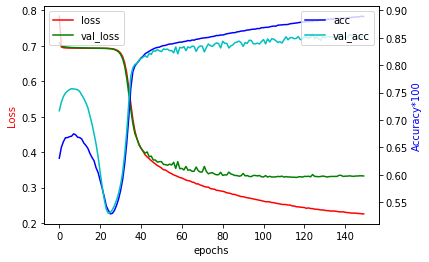

In [0]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
c=0
col= ["r","g","b","c"]
for key1 in ['loss', 'val_loss']:
    #print(hist1.history[key1])
    ax1.plot(hist1.history[key1],label=key1, c=col[c])
    ax1.legend(loc=2)
    c=c+1
for key2 in ['acc', 'val_acc']:
    ax2.plot(hist1.history[key2],label=key2, c=col[c])
    ax2.legend(loc=1)
    c=c+1


ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy*100', color='b')
plt.savefig("/content/drive/My Drive//HCI_prep/Plot_with_VGG_weights_gdi_fcn16_24_02_2020_full.png")

# Test on Test images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


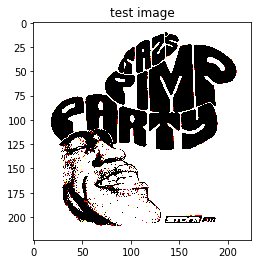

prediction shape (1, 224, 224, 1)
(224, 224, 1)


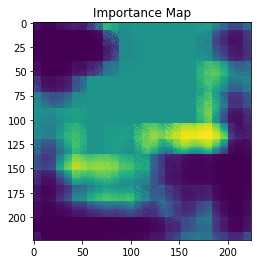

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


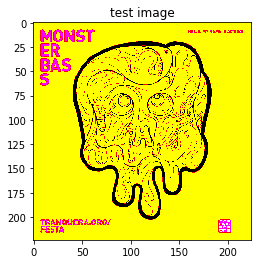

prediction shape (1, 224, 224, 1)
(224, 224, 1)


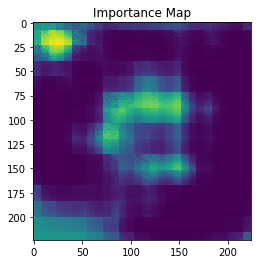

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


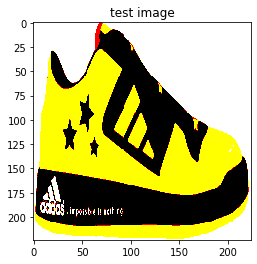

prediction shape (1, 224, 224, 1)
(224, 224, 1)


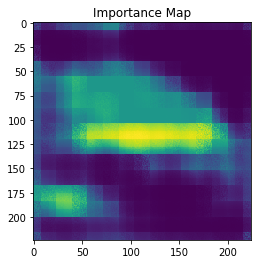

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


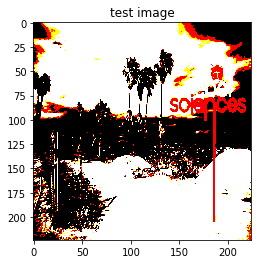

prediction shape (1, 224, 224, 1)
(224, 224, 1)


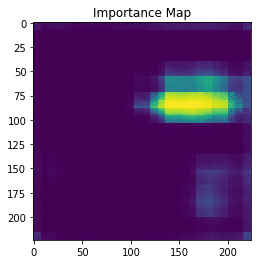

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


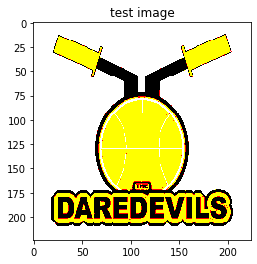

prediction shape (1, 224, 224, 1)
(224, 224, 1)


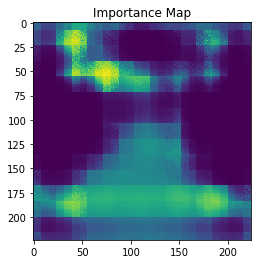

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


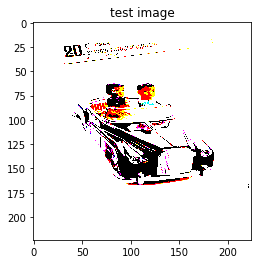

prediction shape (1, 224, 224, 1)
(224, 224, 1)


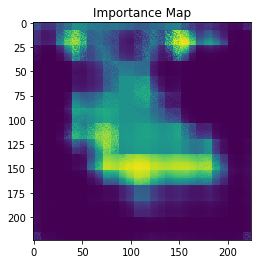

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


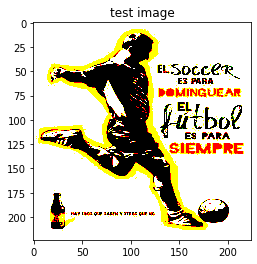

prediction shape (1, 224, 224, 1)
(224, 224, 1)


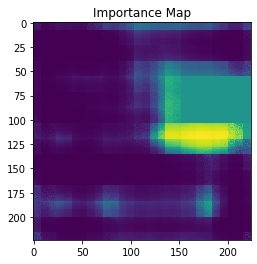

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


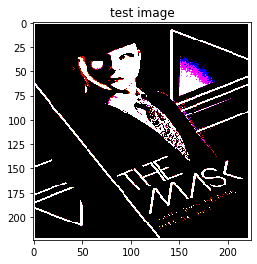

prediction shape (1, 224, 224, 1)
(224, 224, 1)


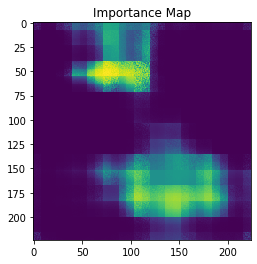

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


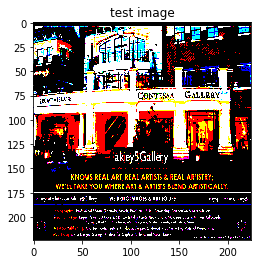

prediction shape (1, 224, 224, 1)
(224, 224, 1)


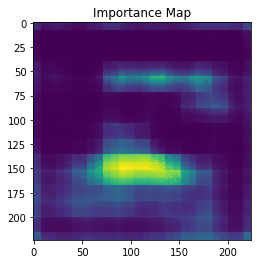

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


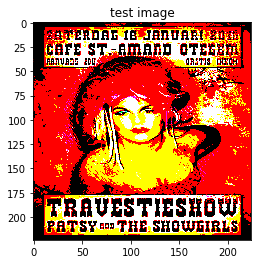

prediction shape (1, 224, 224, 1)
(224, 224, 1)


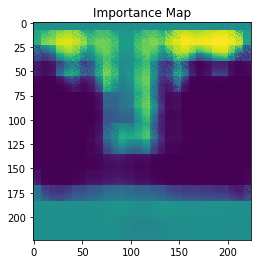

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


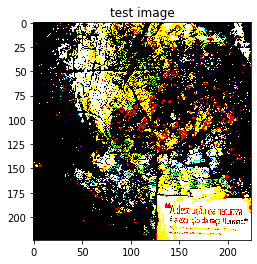

prediction shape (1, 224, 224, 1)
(224, 224, 1)


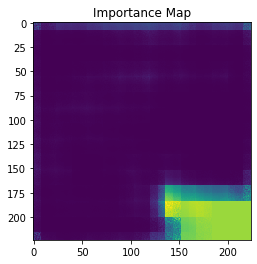

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


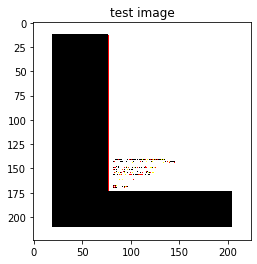

prediction shape (1, 224, 224, 1)
(224, 224, 1)


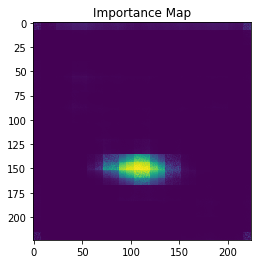

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


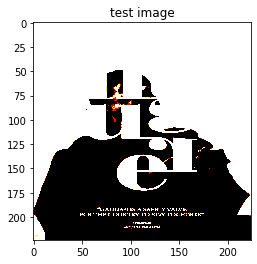

prediction shape (1, 224, 224, 1)
(224, 224, 1)


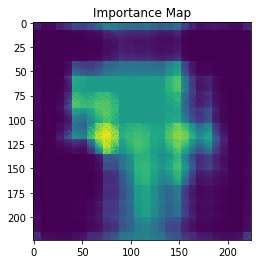

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


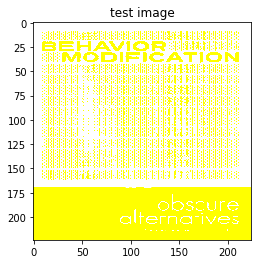

prediction shape (1, 224, 224, 1)
(224, 224, 1)


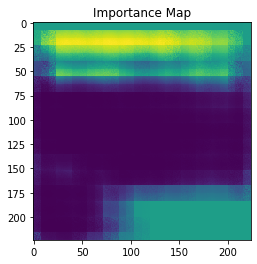

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


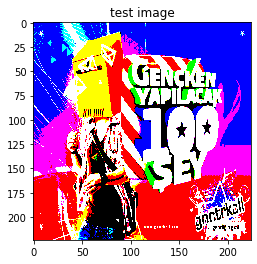

prediction shape (1, 224, 224, 1)
(224, 224, 1)


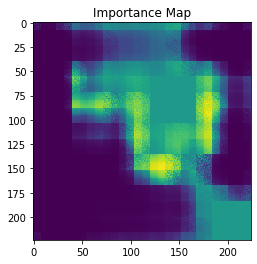

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


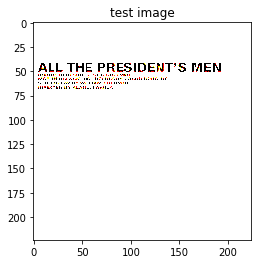

prediction shape (1, 224, 224, 1)
(224, 224, 1)


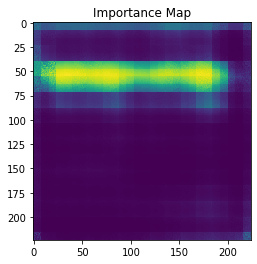

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


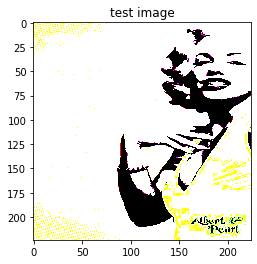

prediction shape (1, 224, 224, 1)
(224, 224, 1)


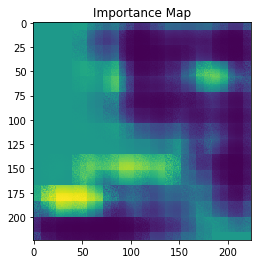

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


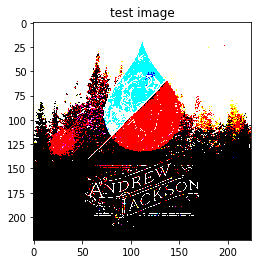

prediction shape (1, 224, 224, 1)
(224, 224, 1)


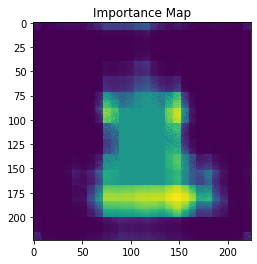

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


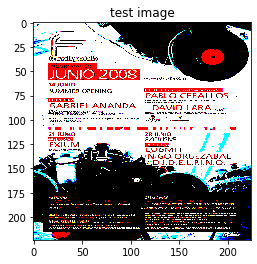

prediction shape (1, 224, 224, 1)
(224, 224, 1)


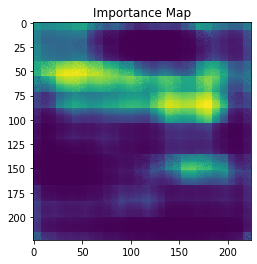

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


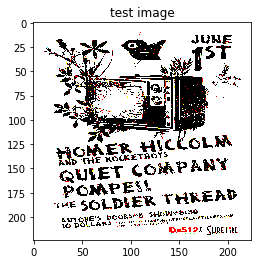

prediction shape (1, 224, 224, 1)
(224, 224, 1)


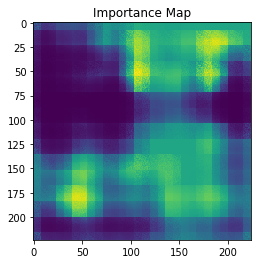

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


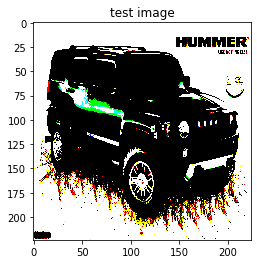

prediction shape (1, 224, 224, 1)
(224, 224, 1)


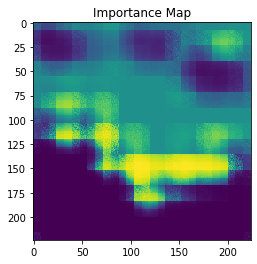

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


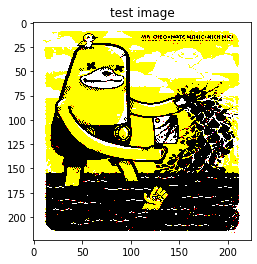

prediction shape (1, 224, 224, 1)
(224, 224, 1)


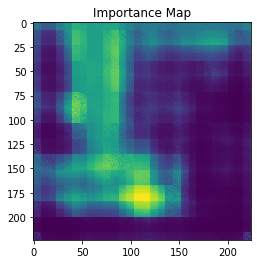

In [0]:
#img = "/content/drive/My Drive/HCI_prep/Dataset_Website1/stimuli/coursera.png"
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import load_model
from PIL import Image
saved_model = load_model("/content/drive/My Drive/HCI_prep/with_VGG_weights_gdi_fcn16_24_02_2020.h5")
#img_is = cv2.imread(img)

for img_is in X_test:

  # show the test image
  img_is=cv2.resize(img_is,(224,224))
  plt.imshow(img_is)
  plt.title("test image")
  plt.show()

  # The test data was preprocessed before, so no processing is required!
  # If not preprocessed then use then use the following commented section.
  '''
  
  # Resize the image
  width, height= 224,224
  img = np.float32(cv2.resize(img_is, ( width, height))) 

  # Meanvalue reduction
  meanval=(104.00699, 116.66877, 122.67892)
  img -= meanval

  X= np.array(img)
  print(X.shape)
  #print(X)
  '''
  img= img_is.reshape(-1,224,224,3)
 
  im_pred= saved_model.predict(img)
  print("prediction shape",im_pred.shape)
  # print(im_pred.max())
  # print(im_pred.min())
  # print(im_pred)

  rescaled_new= im_pred.reshape(224,224,1)
  print(rescaled_new.shape)
  #data=rescaled_new
  #print(rescaled_new)
  #rescaled = (255.0 / data.max() * (data - data.min()))
  #print(rescaled)
  #im_new = Image.fromarray(rescaled)
  #im_new.show()
  rescaled_new=cv2.resize(rescaled_new,(224,224))
  plt.imshow(rescaled_new)
  plt.title("Importance Map")
  plt.show()